In [1]:
################### INSTALL PACKAGES ###################################

# This script uses a package called "INLA" 
# The package helps implement Bayesian methods and helps make some of our steps fast/easy to implement

############# RUN THE FOLLOWING COMMANDS ###################

# install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
# install.packages("fmesher", dependencies = TRUE)
# install.packages("MatrixModels", type = "source")
# install.packages("exactextractr")
# install.packages("sn" ,dependencies = TRUE)
# packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields","png")
# package.check <- lapply(packages, FUN = function(x) {
#     if (!require(x, character.only = TRUE)) {
#         install.packages(x, dependencies = TRUE)
#         library(x, character.only = TRUE, quietly=TRUE)
#     }
# })
# Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

# ##### THE FOLLOWING COMMANDS ARE FOR THE INSTALLATION OF PACKAGES ON LINUX (NASA MAAP) #####
# ##### CONDA-FORGE YOUR WAY THROUGH ANY DEPENDENCIES THAT DID NOT INSTALL ##########

# conda install conda-forge::r-fmesher
# conda install conda-forge::r-exactextractr
# conda install conda-forge::r-sn
# conda install conda-forge::r-inlabru
# conda install conda-forge::r-fields

In [2]:
############## LOAD PACKAGES ###########
library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")
library("png")

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
library(exactextractr)

library(ggplot2)
library(viridis)
library(sn)

Warning message:
“package ‘INLA’ was built under R version 4.4.1”
Loading required package: sp

This is INLA_24.06.27 built 2024-06-27 02:36:04 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation

Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE

terra 1.7.29


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


Loading required

In [21]:
options(repr.plot.width=10, repr.plot.height=10)
aoi = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/GEDI_Imputation/AOI_North.gpkg", quiet = TRUE) %>% st_union() %>% st_transform(crs = 6933) 
GEDI_metrics = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/GEDI_Imputation/GEDI_subset_Ghana_North.gpkg", quiet = TRUE) %>% st_transform(crs = 6933)
GEDI_coords = st_coordinates(GEDI_metrics) 
Metrics <- GEDI_metrics %>% st_drop_geometry()
RH98_Metric <- (Metrics$rh98)
loc.plot <- data.frame(matrix(ncol = 2, nrow = length(RH98_Metric))) # Just create empty list to populated with saved NFI xy locations
n.plot = nrow(loc.plot)
loc.plot[,1] <- as.data.frame(GEDI_coords)$X
loc.plot[,2] <- as.data.frame(GEDI_coords)$Y

In [22]:
# ##### READ OTHER COVARIATES #### 
# CCI <- rast('/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GHA/GHA_Product_AOI/CCI_AOImasked.tif') %>% project("epsg:6933")
# NLang <- rast('/projects/my-public-bucket/Data/NASA_CMS_2023/GEDI_Imputation/ETH_GlobalCanopyHeight_10m_2020_N03W003_Map_6933.tif')
# PALSAR <- rast('/projects/my-public-bucket/Data/NASA_CMS_2023/GEDI_Imputation/PALSAR_HV_db.tif') %>% project("epsg:6933")
# NCEO <- rast('/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GHA/GHA_Product_AOI/NCEO_AGB_2020_Ghana.tif') %>% project("epsg:6933")

In [23]:
# CCI.plot = exactextractr::exact_extract(CCI, st_buffer(GEDI_metrics,25), 'mean')
# NLang.plot = exactextractr::exact_extract(NLang, st_buffer(GEDI_metrics,25), 'mean')
# PALSAR.plot = exactextractr::exact_extract(PALSAR, st_buffer(GEDI_metrics,25), 'mean')
# NCEO.plot = exactextractr::exact_extract(NCEO, st_buffer(GEDI_metrics,25), 'mean')

In [24]:
# plot(sqrt(RH98_Metric),CCI.plot)
# plot(sqrt(RH98_Metric),NLang.plot)
# plot(sqrt(RH98_Metric),PALSAR.plot)
# plot(sqrt(RH98_Metric),NCEO.plot)

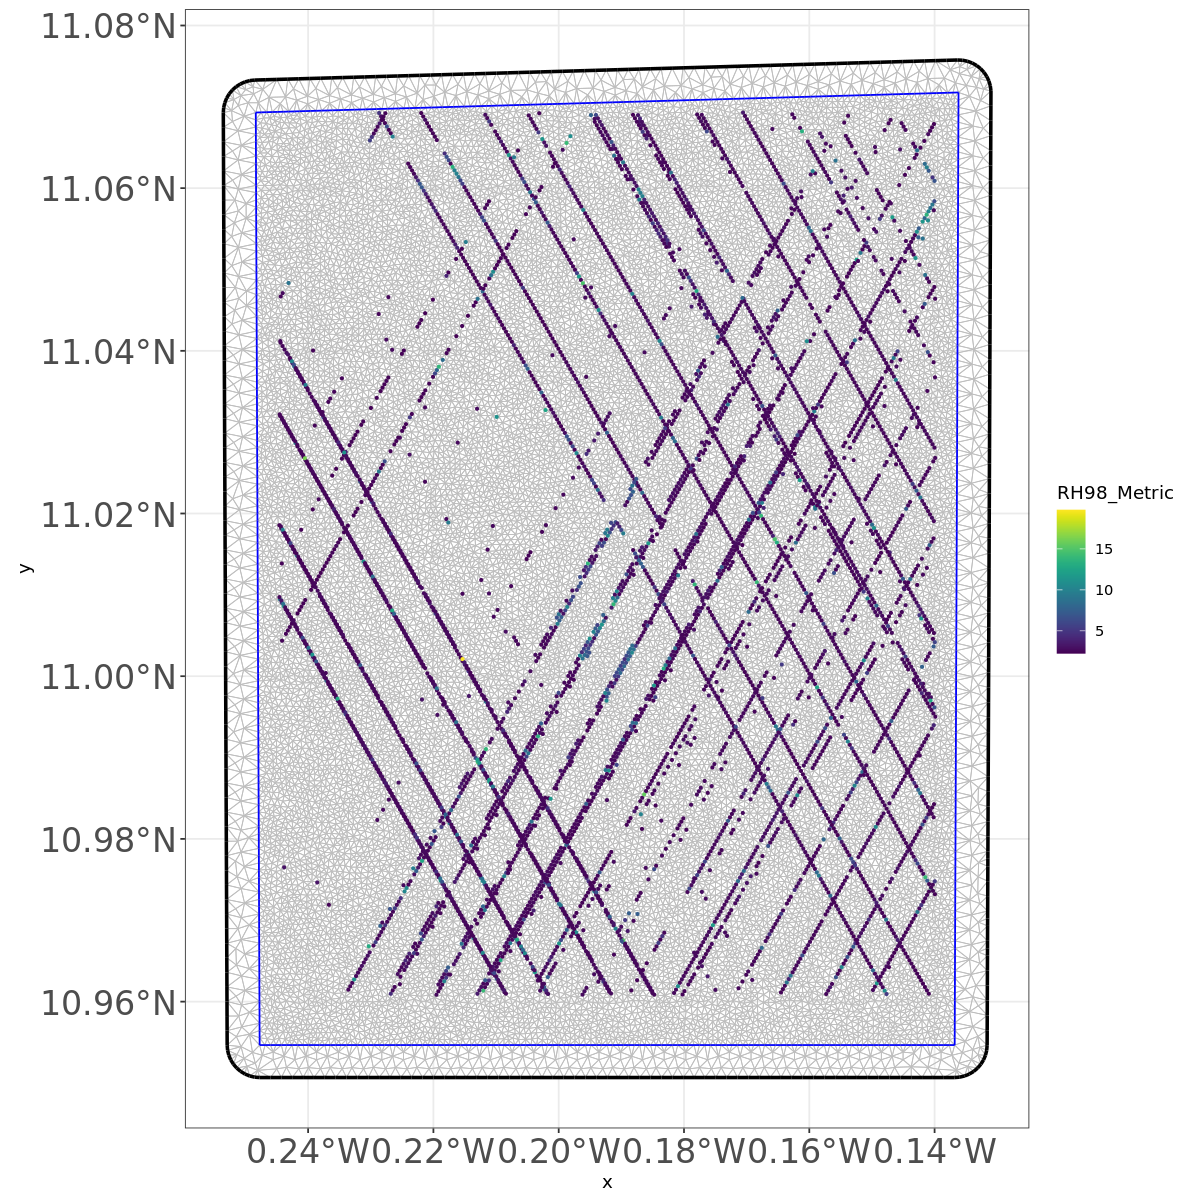

In [36]:
################### MAKING A MESH SURFACE OVER AOI ###################
options(repr.plot.width=10, repr.plot.height=10)

max.edge = 100 ### Let's start with a 50 m maximimum edge size of our mesh. Note, the units of max.edge must be in meters
aoi.buffer = st_buffer(aoi, dist = max.edge*5) # We also make a 5 km buffer around aoi to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(aoi, "Spatial"), as(aoi.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 

# Let's zoom in to a corner, so you can see what the mesh and buffer looks like, and also plot two hypothetical regions where we will eventually predict AGBD
ggplot() + inlabru::gg(data = mesh) + coord_sf(crs = 6933) + theme_bw() + theme(axis.text=element_text(size=20),axis.title=element_text()) +
         geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = RH98_Metric),size=0.5) + #+ xlim(-9.5*10^6, -8*10^6) + ylim(2*10^6, 3*10^6)
         scale_color_viridis() 
k = mesh$n ### This is the resulting number of vertices. It is the ultimate determinant of how computationally hard it will be to solve our model! 
# mesh$loc # This gives you the XY location of the center points of each mesh triangle. 

In [37]:
######################## INTERPOLATING OUR MESH TO EACH PLOT ##################
loc.plot = data.matrix(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot)

# Priors for the varying intercept alpha_tilde
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(3000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(20, 0.01)) # This says the probability that the SD is GREATER than 60 Mg/ha is 0.01

dim(A.plot)
n.plot
k
dim(loc.plot)
nrow(loc.plot)

[1]  5518 24156

[1] 5518

[1] 24156

[1] 5518    2

[1] 5518

In [38]:
### First, we just construct our formula, which we need to provide to INLA #####
formula = RH98 ~ # This is the NFI-estimated AGBD, which we have to predict
  -1 +           # This informs INLA that it should not use a default intercept, but use the one we provide
  intercept +    # Intercept
  f(alpha.spat, model = spde.alpha) # Spatially-varying error term, modelled with spde.alpha

#### Second, we arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(RH98 = RH98_Metric),
                   A = list(1, # tell INLA we expect an intercept, and the projection matrix is just "1"
                            A.plot), # tell INLA we have a mesh projected onto the plot locations for alpha-tilde 
                   effects = list(
                     intercept = rep(1, n.plot), # The intercept just given an index equal to 1
                     alpha.spat = 1:k # The random effects just need to given unique indices at each mesh node.
                   ))

Time used:
    Pre = 0.447, Running = 41.2, Post = 1.91, Total = 43.5 
Fixed effects:
           mean    sd 0.025quant 0.5quant 0.975quant  mode kld
intercept 3.206 0.085      3.042    3.205      3.376 3.205   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model

Model hyperparameters:
                                           mean      sd 0.025quant 0.5quant
Precision for the Gaussian observations   0.363   0.008      0.346    0.362
Range for alpha.spat                    904.772 139.770    664.518  892.943
Stdev for alpha.spat                      0.822   0.050      0.728    0.821
                                        0.975quant    mode
Precision for the Gaussian observations      0.379   0.362
Range for alpha.spat                      1213.523 867.655
Stdev for alpha.spat                         0.924   0.819

Deviance Information Criterion (DIC) ...............: 21649.19
Deviance Information Criterion (DIC, saturated) ....: 5908.06
Effective number of parameters ........

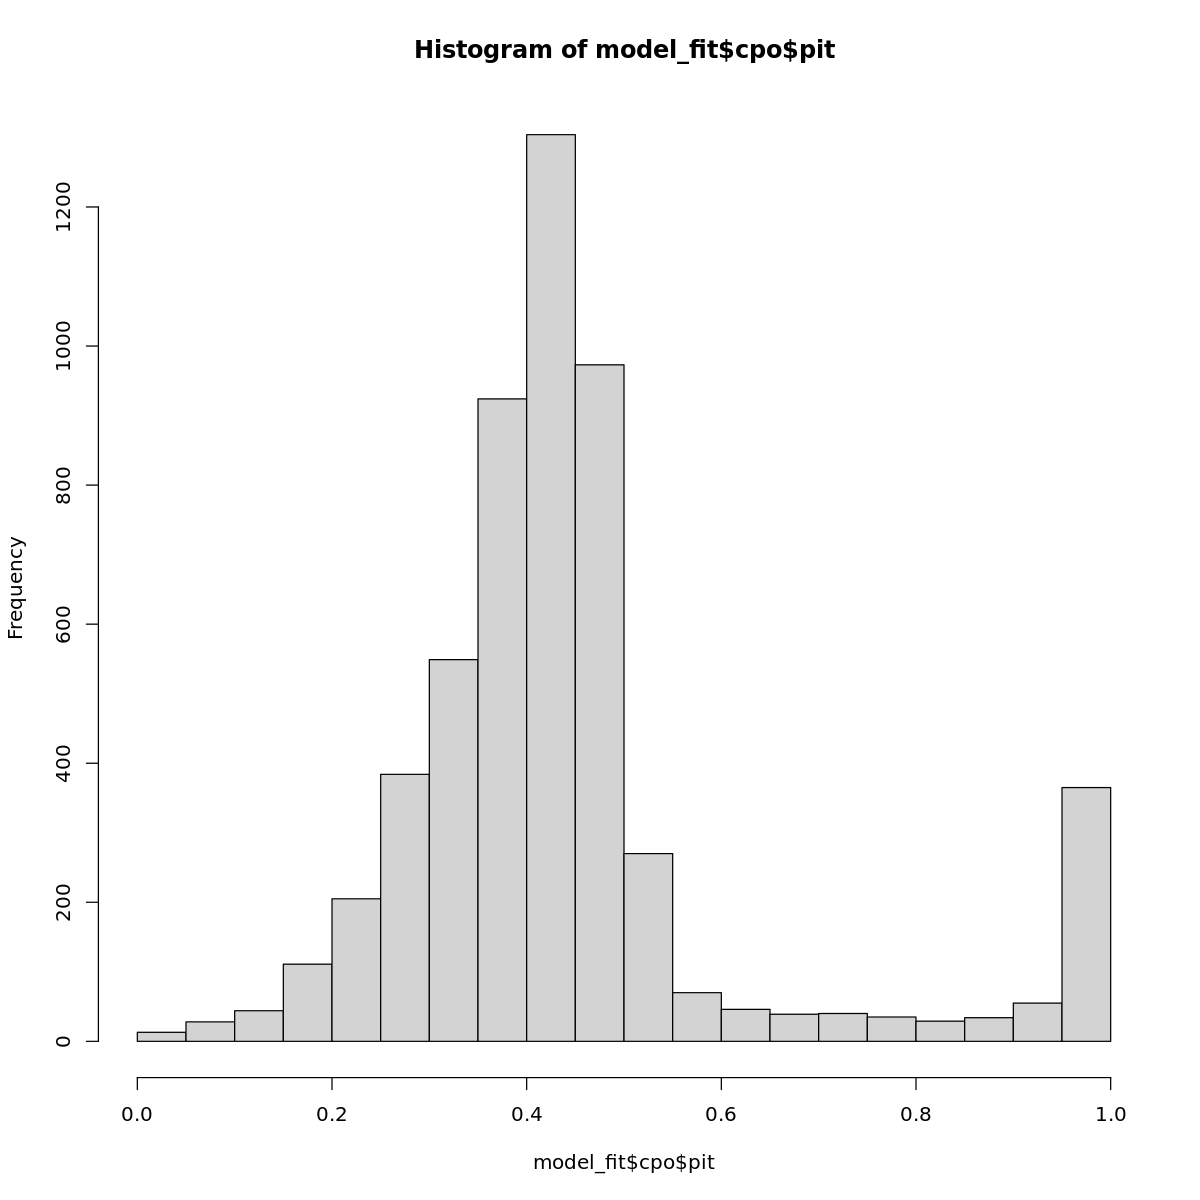

In [39]:
model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # This line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = TRUE, dic = TRUE, waic = TRUE, cpo = TRUE), # As for Bayesian diagnostics, which help understand results
                 verbose = TRUE)
summary(model_fit)
hist(model_fit$cpo$pit, breaks = 20) 
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/GEDI_Imputation/INLA_model_fit.RData")

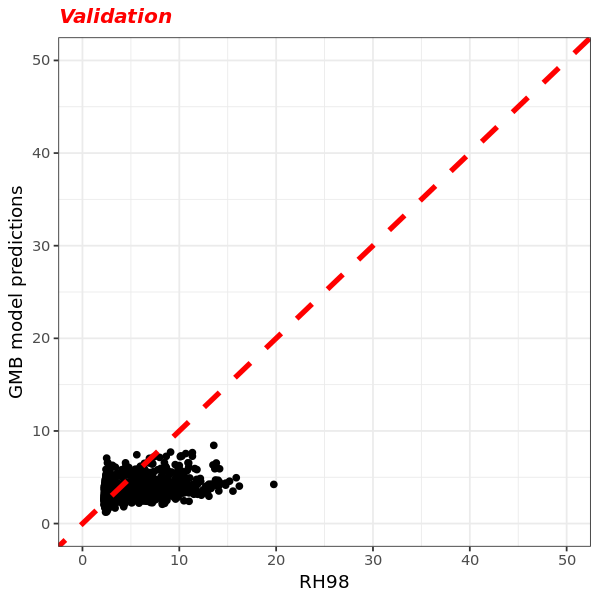

In [40]:
########### LET'S CHECK HOW OUR MODEL PERFORMS ############
options(repr.plot.width=5, repr.plot.height=5)

samples = inla.posterior.sample(n = 20, result = model_fit)  ### Draw 2000 samples
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) 

# # Our prediction function, supplied with both the model parameters and the covariates. 
pred_fun = function(...){
  drop(intercept + 
    A.plot%*%alpha.spat[1:k]) + 
    rnorm(nrow(A.plot), sd = sqrt(1/theta[1])) # INLA stores the precision (1/variance) for the random noise in theta[1]. So 1/theta[1] gives you the variance and square-rooting it gives you the sd
}

pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples))

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, GEDI=RH98_Metric))
ggplot(data = OUTPUT, aes(x = GEDI,y = PRED))+ geom_point() + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,50) + ylim(0,50) + xlab("RH98") + ylab("GMB model predictions") + ggtitle("Validation") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

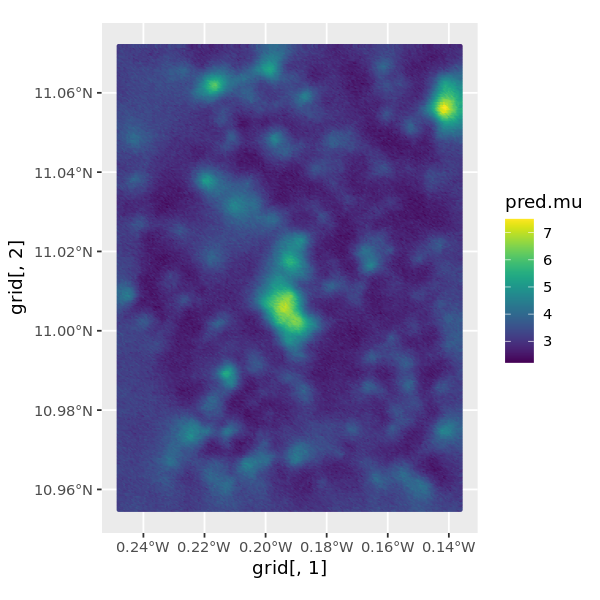

In [35]:
########### LET'S CHECK HOW OUR MODEL PERFORMS ############
options(repr.plot.width=5, repr.plot.height=5)

grid_to_predict = st_make_grid(aoi, cellsize = c(50,50), what = "centers") %>% st_as_sf()
grid = grid_to_predict %>% st_coordinates()

samples = inla.posterior.sample(n = 250, result = model_fit)  ### Draw 2000 samples
A.pred = inla.spde.make.A(mesh = mesh, loc = grid)

# # Our prediction function, supplied with both the model parameters and the covariates. 
pred_fun = function(...){
  drop(intercept + 
    A.pred%*%alpha.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) # INLA stores the precision (1/variance) for the random noise in theta[1]. So 1/theta[1] gives you the variance and square-rooting it gives you the sd
}

pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples))

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

ggplot() + coord_sf(crs = 6933) + geom_point(aes(x = grid[,1], y = grid[,2], col=pred.mu), size = 0.5) + scale_color_viridis()

In [13]:
OUTPUT <- do.call(rbind, Map(data.frame, X=grid[,1], Y=grid[,2], RH98=pred.mu))
df <- st_as_sf(x = OUTPUT, coords = c("X", "Y"), crs = 6933)
st_write(df, dsn='/projects/my-public-bucket/Data/NASA_CMS_2023/GEDI_Imputation/Results.gpkg', layer = 'Results', overwrite=TRUE, quiet = TRUE)

Layer Results in dataset /projects/my-public-bucket/Data/NASA_CMS_2023/GEDI_Imputation/Results.gpkg already exists:
use either append=TRUE to append to layer or append=FALSE to overwrite layer


ERROR: Error in eval(expr, envir, enclos): Dataset already exists.

